# Autonomous Driving Rover
**Leonardo Russo 2015563**

### Introduction

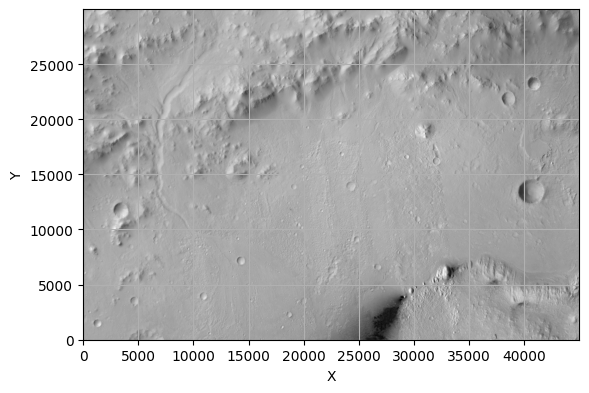

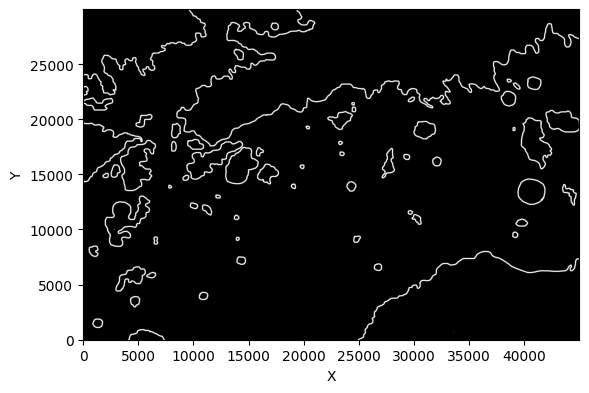

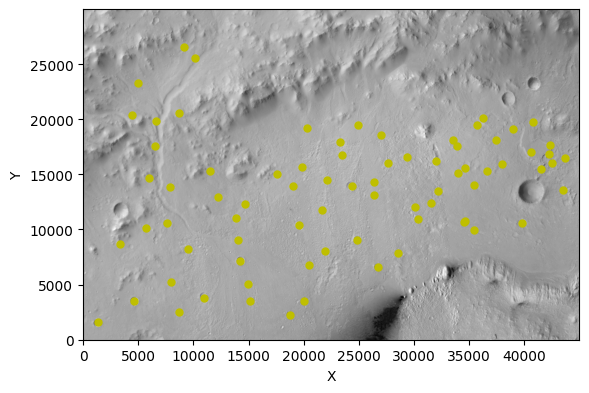

(3000, 4500)


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import library as lib
from scipy.integrate import solve_ivp

# from rich.traceback import install
# install(show_locals = True)

# Set Options
np.set_printoptions(precision=4)


X, Y, map_image, obstacleMap, xLM, yLM, Xvec, Yvec = lib.load_data()

# Define Map Resolution
mapRes = 10     # meters per pixel

# Squeeze Xvec and Yvec -> both these variables must be one-dimensional vectors
Xvec = np.squeeze(Xvec)
Yvec = np.squeeze(Yvec)

# Define Physical Values
L = 3           # m - axles distance
v_max = 4e-2    # m/s - max speed

# Define Specific Poses
P0 = np.array([42.38*1e3, 11.59*1e3, np.pi/2])          # m, m, rad
P1 = np.array([33.07*1e3, 19.01*1e3, np.pi])            # m, m, rad

# Show Original Map
plt.figure()
lib.plot_map(map_image, Xvec, Yvec)
plt.show()

# Obstacle map in grayscale
plt.figure()
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Landmarks on grayscale map
plt.figure()
plt.imshow(map_image, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(obstacleMap.shape)

**Test the Coordinate Conversion**

In [52]:
# Compute Relative States
R0 = lib.P2R(P0, P1)
R1 = lib.P2R(P1, P1)

# Convert backwards the Relative State into Pose State
P0p = lib.R2P(R0, P1)

print('\nThe Initial Pose State is P0:\n', P0)
print('\nThe Relative Pose State is R0:\n', R0)
print("\nThe Backconverted Initial Pose State is P0':\n", P0p)


The Initial Pose State is P0:
 [4.2380e+04 1.1590e+04 1.5708e+00]

The Relative Pose State is R0:
 [1.1905e+04 8.9789e-01 6.7290e-01]

The Backconverted Initial Pose State is P0':
 [4.2380e+04 1.1590e+04 1.5708e+00]


### Task 1: Move to a Pose

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows:
`K = [1e-4, 1.4e-3, -1.8e-3]`


Task 1
______________________________________________________________________ 

The Initial State is:	 [4.2380e+04 1.1590e+04 1.5708e+00]
The Final State is:	 [3.3070e+04 1.9010e+04 3.1416e+00]
The Desired State is:	 [3.3070e+04 1.9010e+04 3.1416e+00]

The Delta State is:	 [1.0022e-01 1.2456e-08 1.6701e-06]
Final Time is:		 4.68 days


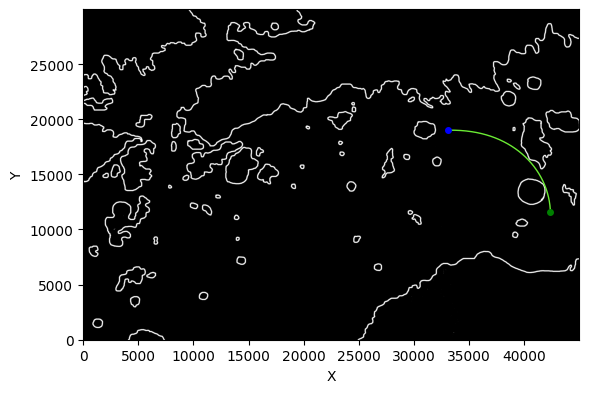

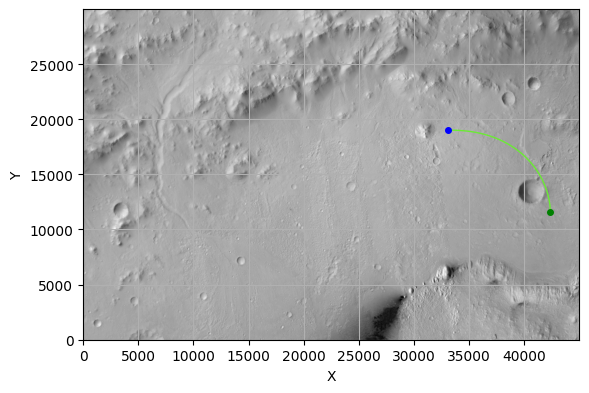

In [53]:
# Define the event function
rho_tol = 0.1    # m
def event(t, R):
    return R[0] - rho_tol
event.terminal = True

# Define Initial Relative State
R0 = lib.P2R(P0, P1)

# Define Time Domain
t0 = 0              # seconds
tf = lib.days2sec(30)            # seconds - maximum time for the maneuver
N = 10000            # time steps
tspan = np.linspace(t0, tf, N)

# Select Gains
K = np.array([1e-4, 1.4e-3, -1.8e-3])

# Solve the differential equation
sol = solve_ivp(lambda t, R: lib.KinematicModel(t, R, K), [t0, tf], R0, method='RK45', t_eval=tspan, events=event)
tspan = sol.t
R = sol.y
P = lib.R2P(R, P1)

# Check for Obstacles
map_indices = np.array([lib.get_indices(P[0:2, i], X, Y, mapRes) for i in range(P.shape[1])])    # convert each point in the trajectory to map indices

if lib.check_obstacles(map_indices, obstacleMap):
    print('\n\nThe Trajectory intersects with an Obstacle!\n\n')

P1r = P[:, -1]      # store the real final state


# Log Results
print('\nTask 1\n' + '_'*70, '\n\nThe Initial State is:\t', P0)
print('The Final State is:\t', P[:, -1])
print('The Desired State is:\t', P1)
print('\nThe Delta State is:\t', P[:, -1] - P1)
print('Final Time is:\t\t {:.2f} days'.format(lib.sec2days(tspan[-1])))

# Obstacle map in grayscale
plt.figure()
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(P[0, :], P[1, :], '#6beb34', linestyle='-', linewidth=1)
plt.plot(P0[0], P0[1], 'go', markersize=4)
plt.plot(P1[0], P1[1], 'bo', markersize=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Show Trajectory
plt.figure("Task 1 - Trajectory")
lib.plot_map(map_image, Xvec, Yvec)
plt.plot(P[0, :], P[1, :], '#6beb34', linestyle='-', linewidth=1)
plt.plot(P0[0], P0[1], 'go', markersize=4)
plt.plot(P1[0], P1[1], 'bo', markersize=4)
plt.show()




### Task 2: A* Algorithm

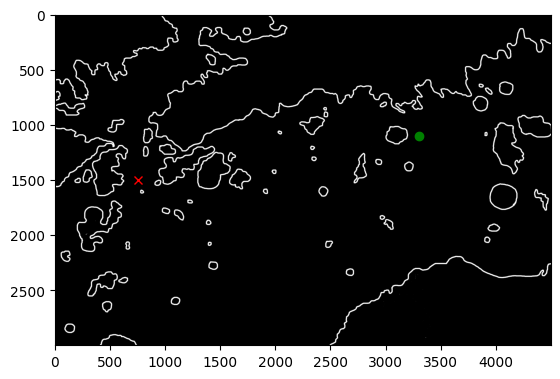

In [54]:
# Define Start and End Coordinates
start = P1r[0:2]
end = np.array([10.87e3, 25.67e3])

start = lib.get_indices(start, X, Y, mapRes)
end = lib.get_indices(end, X, Y, mapRes)
end = np.array([1500, 750])

# Obstacle map in grayscale
plt.figure("Task 1 - Trajectory")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([start[1]], [start[0]], c='green', marker='o')
plt.plot([end[1]], [end[0]], c='red', marker='x')
plt.show()

In [55]:
def A_star(start, end, obstacle_map):
    class Node:
        def __init__(self, position, parent):
            self.position = tuple(position)  # Store position as a tuple
            self.parent = parent
            self.g = 0  # Distance to start node
            self.h = 0  # Distance to goal node
            self.f = 0  # Total cost

        def __eq__(self, other):
            return self.position == other.position

        def __hash__(self):
            return hash(self.position)  # Hash based on position for use in sets

    # Heuristic function for distance
    def heuristic(a, b):
        return max(abs(a[0]-b[0]), abs(a[1]-b[1])) + 0.41421356237 * min(abs(a[0]-b[0]), abs(a[1]-b[1]))

    open_list = []
    closed_list_set = set()

    start_node = Node(start, None)
    end_node = Node(end, None)
    open_list.append(start_node)

    while len(open_list) > 0:
        current_node = min(open_list, key=lambda node: node.f)
        open_list.remove(current_node)
        closed_list_set.add(current_node)

        if current_node.position == end_node.position:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # Return reversed path

        # Generate children
        (x, y) = current_node.position
        neighbors = [(x, y-1), (x-1, y-1), (x-1, y), (x-1, y+1), (x, y+1), (x+1, y+1), (x+1, y), (x+1, y-1)]

        for next_node in neighbors:
            # Make sure within range
            if next_node[0] > (len(obstacle_map) - 1) or next_node[0] < 0 or next_node[1] > (len(obstacle_map[0]) - 1) or next_node[1] < 0:
                continue

            # Make sure walkable terrain
            if int(obstacle_map[next_node[0]][next_node[1]]) == 255:  # Convert to int for comparison
                continue

            # Create new node
            neighbor = Node(next_node, current_node)

            # Check if the neighbor is in the closed list
            if neighbor in closed_list_set:
                continue

            # Create the f, g, and h values
            neighbor.g = current_node.g + 1
            neighbor.h = heuristic(neighbor.position, end_node.position)
            neighbor.f = neighbor.g + neighbor.h

            # Check if neighbor is in open list and if it has a lower f value
            if add_to_open(open_list, neighbor):
                open_list.append(neighbor)

    return None  # No path found

# Function to check if a neighbor should be added to the open list
def add_to_open(open_list, neighbor):
    for node in open_list:
        if neighbor == node and neighbor.f >= node.f:
            return False
    return True


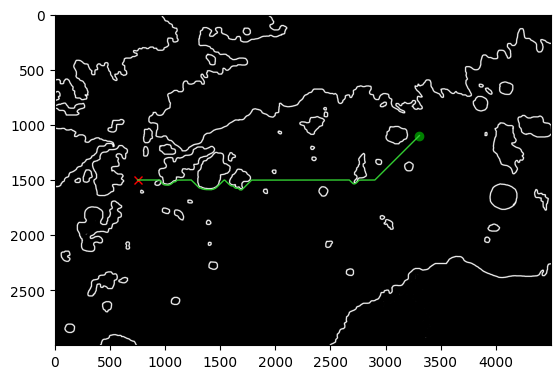

In [56]:
path = A_star(start, end, obstacleMap)
path = np.array(path)

# Obstacle map in grayscale
plt.figure("Task 2 - Pathfinding")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([start[1]], [start[0]], c='green', marker='o')
plt.plot([end[1]], [end[0]], c='red', marker='x')
plt.plot(path[:, 1], path[:, 0], c='limegreen', linestyle='-', linewidth=1)
plt.show()